In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# A Simple Starter Code for the AJL Competition

@Cindy Deng

---


Hi! This starter code is designed to help you get familiar with basic Kaggle operations and guide you through the basic workflow of a machine learning project. 

The code outlines essential steps including data loading, preprocessing, model building, training, and generating predictions. Each section serves as a foundation, but there are many ways to enhance each step to improve your final model's accuracy. Feel free to experiment with different data augmentation techniques, model architectures, and tuning methods to optimize your final results! Some amazing tutorials are available through your AI Studio course in Canvas / in the 'Resource' section of this Kaggle competition.

Good luck and have fun!

---

## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [2]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [3]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'
test_df["md5hash"] = test_df["md5hash"].str.replace(".jpg", "", regex=False)


# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df.apply(lambda row: os.path.join('/kaggle/input/bttai-ajl-2025/train/train', row['label'], row['md5hash']), axis=1)

In [4]:
# Check the first few rows to understand the structure
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

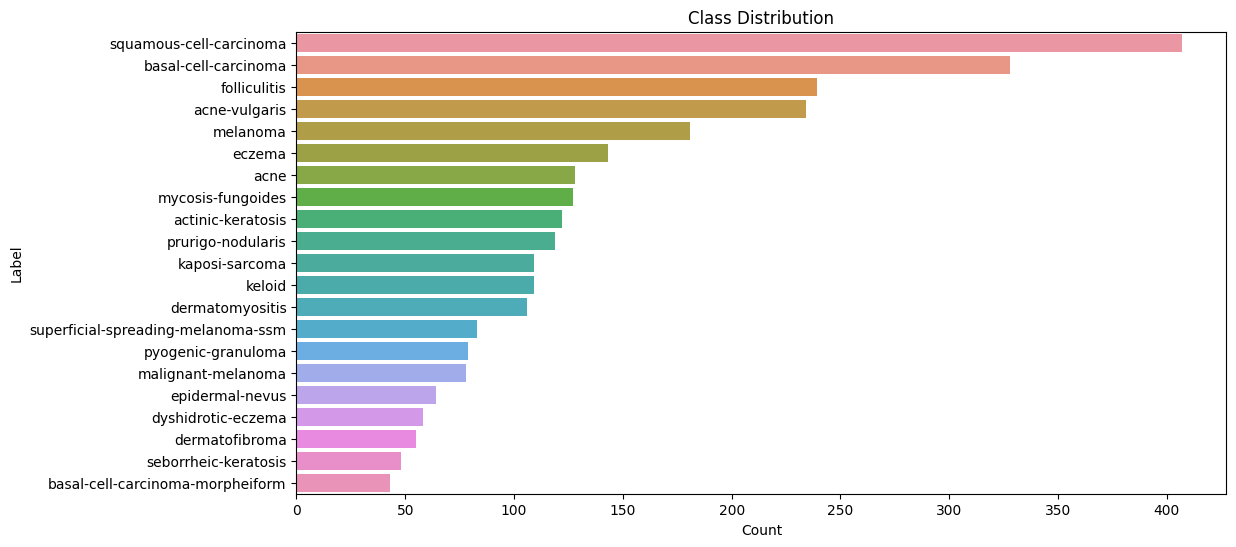

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index)
plt.title("Class Distribution")
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()

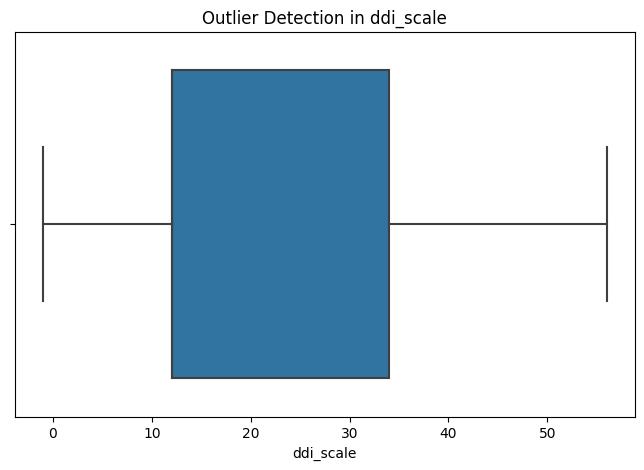

In [6]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=train_df['ddi_scale'])
plt.title("Outlier Detection in ddi_scale")
plt.show()

In [7]:
missing_values = train_df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 qc    2770
dtype: int64


In [8]:
duplicate_rows = train_df.duplicated().sum()
print(f"🔍 Duplicate Rows Found: {duplicate_rows}")

🔍 Duplicate Rows Found: 0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


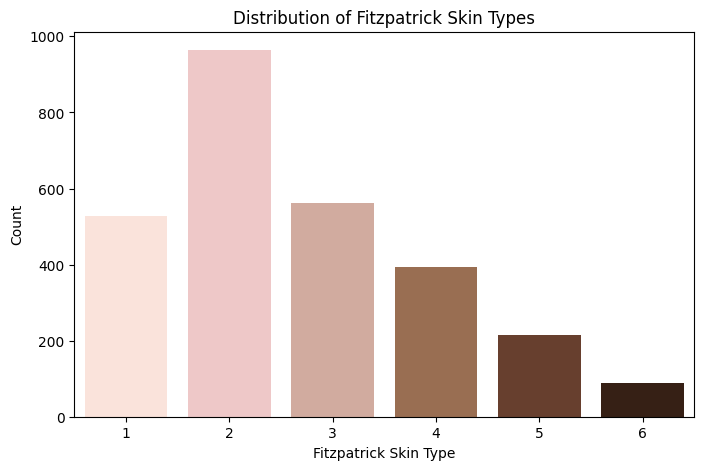

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define Fitzpatrick skin tone shades (matching real-world tones)
fitzpatrick_colors = {
    1: "#ffe0d6",  # Very fair
    2: "#f4c2c2",  # Fair
    3: "#d9a797",  # Medium
    4: "#a56b46",  # Olive
    5: "#703b25",  # Dark Brown
    6: "#3b1e10"   # Deeply Pigmented
}

# Filter out invalid values
valid_skin_types = [1, 2, 3, 4, 5, 6]
train_df = train_df[train_df['fitzpatrick_scale'].isin(valid_skin_types)]

# Sort unique Fitzpatrick types
unique_fitzpatrick = sorted(train_df['fitzpatrick_scale'].unique())

# Create the plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x=unique_fitzpatrick, 
    y=[(train_df['fitzpatrick_scale'] == i).sum() for i in unique_fitzpatrick], 
    palette=[fitzpatrick_colors[i] for i in unique_fitzpatrick]
)

# Labels and title
plt.title("Distribution of Fitzpatrick Skin Types")
plt.xlabel("Fitzpatrick Skin Type")
plt.ylabel("Count")

# Show the plot
plt.show()


## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


In [10]:
# 3. Data Preprocessing
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Define image data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory paths
train_dir = '/kaggle/input/bttai-ajl-2025/train/train/'

In [11]:
def create_generator(dataframe, directory, batch_size=32, target_size=(128, 128)):
    """
    Template function to create image generators.
    Students should complete this function to load images and labels properly.
    """
    # Fill in the correct flow_from_dataframe parameters
    generator = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path',  # Use combined path
        y_col='encoded_label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        validate_filenames=False  # Disable strict filename validation
    )
    return generator

In [12]:
# Create generators
train_generator = create_generator(train_data, train_dir)
val_generator = create_generator(val_data, train_dir)

Found 2201 non-validated image filenames.
Found 551 non-validated image filenames.


In [13]:
train_csv_path = '/kaggle/input/bttai-ajl-2025/train.csv'
train_df = pd.read_csv(train_csv_path)
print("Shape of DataFrame:", train_df.shape)
print("Column names:", train_df.columns)
print("Data types:\n", train_df.dtypes)
print("Summary statistics:\n", train_df.describe())

Shape of DataFrame: (2860, 8)
Column names: Index(['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label',
       'nine_partition_label', 'three_partition_label', 'qc', 'ddi_scale'],
      dtype='object')
Data types:
 md5hash                  object
fitzpatrick_scale         int64
fitzpatrick_centaur       int64
label                    object
nine_partition_label     object
three_partition_label    object
qc                       object
ddi_scale                 int64
dtype: object
Summary statistics:
        fitzpatrick_scale  fitzpatrick_centaur    ddi_scale
count        2860.000000          2860.000000  2860.000000
mean            2.524476             2.095455    23.547552
std             1.474428             1.510942    15.530522
min            -1.000000            -1.000000    -1.000000
25%             2.000000             1.000000    12.000000
50%             2.000000             2.000000    12.000000
75%             3.000000             3.000000    34.000000
max        

In [14]:
class_column = "label"  # Change to the correct column name
if class_column in train_df.columns:
    class_distribution = train_df[class_column].value_counts()
    print("Class Distribution:\n", class_distribution)
else:
    print(f"Error: '{class_column}' column not found in dataset.")

Class Distribution:
 label
squamous-cell-carcinoma               407
basal-cell-carcinoma                  328
folliculitis                          239
acne-vulgaris                         234
melanoma                              181
eczema                                143
acne                                  128
mycosis-fungoides                     127
actinic-keratosis                     122
prurigo-nodularis                     119
kaposi-sarcoma                        109
keloid                                109
dermatomyositis                       106
superficial-spreading-melanoma-ssm     83
pyogenic-granuloma                     79
malignant-melanoma                     78
epidermal-nevus                        64
dyshidrotic-eczema                     58
dermatofibroma                         55
seborrheic-keratosis                   48
basal-cell-carcinoma-morpheiform       43
Name: count, dtype: int64


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical'  # Adjust based on your labels (e.g., 'binary' for two classes)
)

Found 2860 images belonging to 21 classes.


## 4. Build the model


In [16]:
# TODO: You should implement the model architecture here.
# Feel free to explore different model types that best serve your purpose.
from sklearn.preprocessing import LabelEncoder

# Assuming 'label' is the name of the column with categorical labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])
def build_model(input_shape=(128, 128, 3), num_classes=10):
    model = Sequential()
    
    # 1st Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 2nd Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 3rd Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the output from Conv layers
    model.add(Flatten())
    
    # Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    
    # Output Layer (for classification)
    model.add(Dense(num_classes, activation='softmax'))  # 'softmax' for multi-class classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model with the desired input shape and number of classes
model = build_model(input_shape=(128, 128, 3), num_classes=len(train_df['encoded_label'].unique()))

# 3. Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 21)                  │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,307,349 (12.62 MB)

 Trainable params: 3,307,349 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

# Loading images


In [17]:
from tensorflow.keras.preprocessing import image  # Import the image module
import os
import numpy as np
import pandas as pd
def load_image(image_path, target_size=(128, 128)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize image
    return img_array

# Load images from the training dataset
train_images = []
train_labels = []
image_dir = '/kaggle/input/bttai-ajl-2025/train/train/'

for disease in os.listdir(image_dir):  # Loop through categories
    disease_path = os.path.join(image_dir, disease)
    
    if os.path.isdir(disease_path):
        for img_name in os.listdir(disease_path):
            img_path = os.path.join(disease_path, img_name)
            train_images.append(load_image(img_path))
            train_labels.append(disease)  # Add disease name as label

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Convert labels to numerical values
train_labels = pd.get_dummies(train_labels).values

## 5. Train the Model


In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.utils import to_categorical

# Define image size
image_height = 128
image_width = 128

# Path to the training dataset (update this path)
train_dir = '/kaggle/input/bttai-ajl-2025/train/train'  # Corrected path to the train directory

# Get the categories (folder names) from the training directory
categories = os.listdir(train_dir)

# Initialize lists for images (X) and labels (y)
X = []
y = []

# Loop over each category to load images and their corresponding labels
for label, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        
        # Load and resize image
        img = load_img(img_path, target_size=(image_height, image_width))
        
        # Convert image to array
        img_array = img_to_array(img)
        
        # Append image data to X and its corresponding label to y
        X.append(img_array)
        y.append(label)

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Normalize the images (scale pixel values between 0 and 1)
X = X / 255.0

# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(categories))

# Split the dataset into training and test (validation) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Check the shapes of the resulting arrays
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2288, 128, 128, 3) (572, 128, 128, 3) (2288, 21) (572, 21)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the CNN model
cnn_model = Sequential()

# Add layers (you can modify this according to your needs)
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(21, activation='softmax'))  # 21 classes for multi-class classification

# Compile the model
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Now fit the model
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 420ms/step - accuracy: 0.1069 - loss: 3.3808 - val_accuracy: 0.1538 - val_loss: 2.7603
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 414ms/step - accuracy: 0.1738 - loss: 2.7247 - val_accuracy: 0.1696 - val_loss: 2.6810
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 414ms/step - accuracy: 0.2689 - loss: 2.4304 - val_accuracy: 0.2080 - val_loss: 2.5782
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 415ms/step - accuracy: 0.4101 - loss: 1.9653 - val_accuracy: 0.1993 - val_loss: 2.7122
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 412ms/step - accuracy: 0.5683 - loss: 1.4533 - val_accuracy: 0.2413 - val_loss: 2.8505
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 417ms/step - accuracy: 0.7218 - loss: 1.0258 - val_accuracy: 0.2483 - val_loss: 3.1875
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 421ms/step - accuracy: 0.8254 - loss: 0.6451 - val_accuracy: 0.2657 - val_loss: 3.7104
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 413ms/step - accuracy: 0.8903 - loss: 0.4151 - val_accu

In [21]:
from tensorflow.keras.utils import to_categorical
# Now fit the model with y_train directly, as it should be one-hot encoded
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 421ms/step - accuracy: 0.9730 - loss: 0.1406 - val_accuracy: 0.2378 - val_loss: 5.1591
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 416ms/step - accuracy: 0.9906 - loss: 0.0776 - val_accuracy: 0.2570 - val_loss: 6.1114
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 424ms/step - accuracy: 0.9804 - loss: 0.0944 - val_accuracy: 0.2395 - val_loss: 5.6808
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 415ms/step - accuracy: 0.9825 - loss: 0.0906 - val_accuracy: 0.2255 - val_loss: 6.1947
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 426ms/step - accuracy: 0.9818 - loss: 0.1008 - val_accuracy: 0.2413 - val_loss: 6.1105
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.9826 - loss: 0.0769 - val_accuracy: 0.2448 - val_loss: 6.2249
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 411ms/step - accuracy: 0.9955 - loss: 0.0322 - val_accuracy: 0.2273 - val_loss: 6.4936
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 421ms/step - accuracy: 0.9900 - loss: 0.0534 - val_accu

# Prediction Model

In [22]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to predict a new image
def predict_new_image(image_path, model, categories):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(128, 128))  # Resize to match training data
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)  # Get class with highest probability
    
    # Get class label
    class_label = categories[predicted_class]
    
    print(f"Predicted class: {class_label}")
    return class_label


# make a submission

In [23]:
import pandas as pd
import numpy as np

# Load datasets
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

# Ensure the required columns exist in the test dataset
if 'md5hash' not in test_df.columns:
    raise ValueError("❌ ERROR: 'md5hash' column not found in test dataset!")
# class names listed out previously when going through class columns
class_names = [
    'squamous-cell-carcinoma',
    'basal-cell-carcinoma',
    'folliculitis',
    'acne-vulgaris',
    'melanoma',
    'eczema',
    'acne',
    'mycosis-fungoides',
    'actinic-keratosis',
    'prurigo-nodularis',
    'kaposi-sarcoma',
    'keloid',
    'dermatomyositis',
    'superficial-spreading-melanoma-ssm',
    'pyogenic-granuloma',
    'malignant-melanoma',
    'epidermal-nevus',
    'dyshidrotic-eczema',
    'dermatofibroma',
    'seborrheic-keratosis',
    'basal-cell-carcinoma-morpheiform'
]
test_df['label'] = np.random.choice(class_names, size=len(test_df))  # Replace with actual predictions

# Create submission file with only 'md5hash' and 'label' columns
submission_df = test_df[['md5hash', 'label']]

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

# Display confirmation
print("\n✅ Final submission file preview:")
print(submission_df.head())
print(f"\n🎉 Submission file saved successfully as 'submission.csv'!")


✅ Final submission file preview:
                            md5hash                 label
0  0844ae634f0e6e7ef1f73c2aeecbae0e         acne-vulgaris
1  3b290d262098f761d719aa07cf36c040  basal-cell-carcinoma
2  cf561d08ac46d0fda678bff6621005ee         acne-vulgaris
3  e6371069be05c6b0a95b4b3f1bacc9a5    pyogenic-granuloma
4  f76cddb37265f97508f159078dcc7e7c              melanoma

🎉 Submission file saved successfully as 'submission.csv'!
